# Strains
In this tutorial, we explain how to use the functions in the strain module. We take a look at the relevance of higher harmonics and how to use the output.

In [1]:
%matplotlib inline

Let's import the strain functions and also some other common stuff.

In [16]:
import legwork.strain as strain

import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

In [3]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.7 * fs,
          'ytick.labelsize': 0.7 * fs}
plt.rcParams.update(params)

## Introduction to function usage

We will focus mainly on the strain function, `h_0_n` but `h_c_n` works identically except it computes the *characteristic* strain amplitude rather than the plain old strain amplitude.

It is important to keep in mind that the shape of the output of these functions will always be `(number of sources, number of harmonics)`. Therefore, even if you only supply a single source and ask for a single harmonic then the function will still supply a 2D array of shape `(1, 1)`.

In [4]:
# example with single source
h_0_2 = strain.h_0_n(10 * u.Msun, 1e-3 * u.Hz, 0.1, 2, 8 * u.kpc)
print("The strain array that is returned is {}".format(h_0_2),
      "which has a shape of {}".format(h_0_2.shape))

The strain array that is returned is [[9.5482392e-21]] which has a shape of (1, 1)


Let's repeat that exercise but for many sources and many harmonics just to emphasise what the shape looks like.

In [5]:
# create 100 random sources
n_sources = 100
m_c = np.random.uniform(0, 10, n_sources) * u.Msun
f_orb = 10**(np.random.uniform(-5, 0, n_sources)) * u.Hz
ecc = np.random.uniform(0, 1, n_sources)
dist = np.random.uniform(0, 8, n_sources) * u.kpc

# get an array of the first 50 harmonics
n_harmonics = 50
harmonics = np.arange(1, n_harmonics + 1).astype(int)

# calculate the strain
h_0_n = strain.h_0_n(m_c=m_c, f_orb=f_orb, ecc=ecc, n=harmonics, dist=dist)
print("The shape of this array is {},".format(h_0_n.shape),
      "as we would expect since n_sources is {}".format(n_sources),
      "and n_harmonics is {}".format(n_harmonics))

The shape of this array is (100, 50), as we would expect since n_sources is 100 and n_harmonics is 50


Then we can access the strain of a particular source and harmonics by using Python slices/indices like so

In [6]:
ind_source = np.random.choice(np.arange(n_sources).astype(int))
ind_harmonic = np.random.choice(np.arange(n_harmonics).astype(int))

chosen_strain = h_0_n[ind_source, ind_harmonic]

print("The strain of source {} at n = {}".format(ind_source, ind_harmonic + 1),
      "is {}".format(chosen_strain))

The strain of source 74 at n = 17 is 1.2251982619007732e-27


Additionally, we may only be interested in the *total* strain for each source rather than keeping track of the strain in each harmonic. In this case we simply need to sum over the correct axis to get the total.

In [7]:
h_0 = h_0_n.sum(axis=1)
print("The number of sources is {},".format(n_sources),
      "hence the shape of `h_0` is {}".format(h_0.shape))

The number of sources is 100, hence the shape of `h_0` is (100,)


## Some example uses

Now that we've covered how the functions work, let's explore some examples of how we can use them!

### Circular binaries: effect of mass

For circular binaries only the $n = 2$ harmonic has any signal and hence we can plot how the strains change with orbital frequency (assuming a fixed distance and chirp mass)

In [8]:
# pick some fixed values and a range for frequency
m_c = 10 * u.Msun
f_orb = np.logspace(-5, 0, 100) * u.Hz
dist = 8 * u.kpc
ecc = 0.0

In [9]:
# compute second harmonic for each and flatten to reduce to 1D array
h_0_2 = strain.h_0_n(m_c, f_orb, ecc, 2, dist).flatten()
h_c_2 = strain.h_c_n(m_c, f_orb, ecc, 2, dist).flatten()

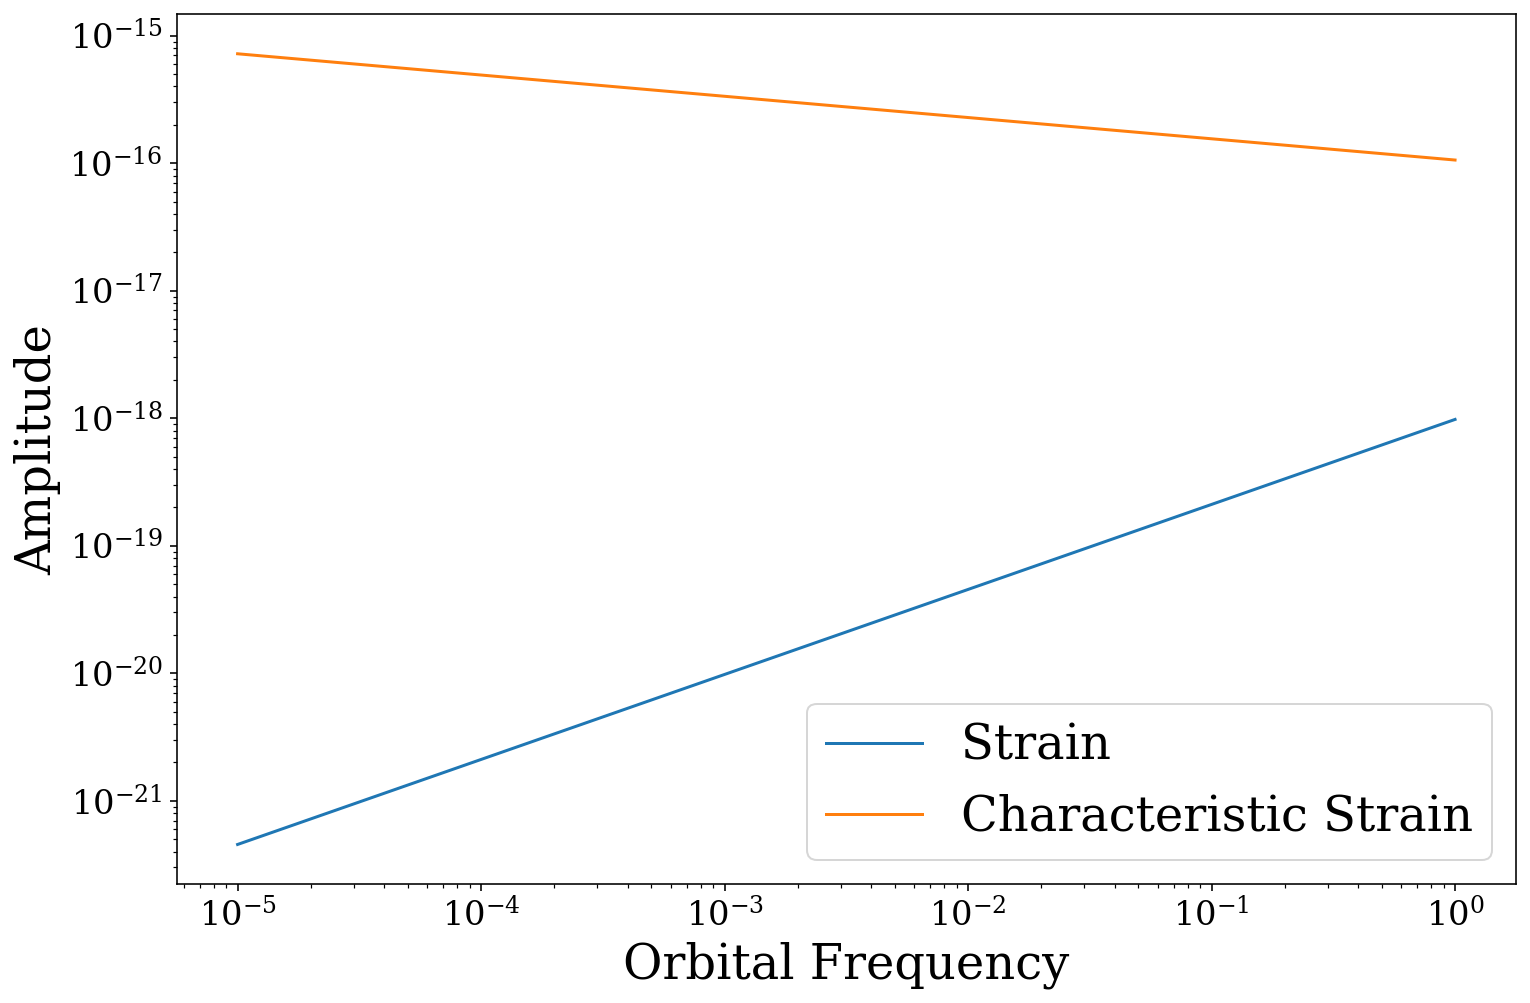

In [10]:
# add the two lines
plt.loglog(f_orb.value, h_0_2, label="Strain")
plt.loglog(f_orb.value, h_c_2, label="Characteristic Strain")

# label the axes
plt.xlabel("Orbital Frequency")
plt.ylabel("Amplitude")

# show a legend and the plot
plt.legend()
plt.show()

So you can see that the strain increases with frequency whilst the characteristic strain actually *decreases*. 

### Eccentric binaries: harmonic distribution
It's also interesting to look at how the strain is spread over multiple harmonics as we increase eccentricity. Let's take a look at how the strength of the $n = 2, 3, 4$ harmonics change with eccentricity (with fixed frequency, chirp mass and distance).

In [11]:
# range for eccentricities (limited to 0.9 to reduce number harmonics needed)
ecc = np.linspace(0.01, 0.9, 1000)

# fixed values
m_c = np.ones_like(ecc) * 10 * u.Msun
f_orb = np.ones_like(ecc) * 1e-3 * u.Hz
dist = np.ones_like(ecc) * 8 * u.kpc

In [12]:
# calculate the strain for the first 500 harmonics
ecc_plot_h_0_n = strain.h_0_n(m_c, f_orb, ecc,
                              np.arange(1, 500 + 1).astype(int), dist)

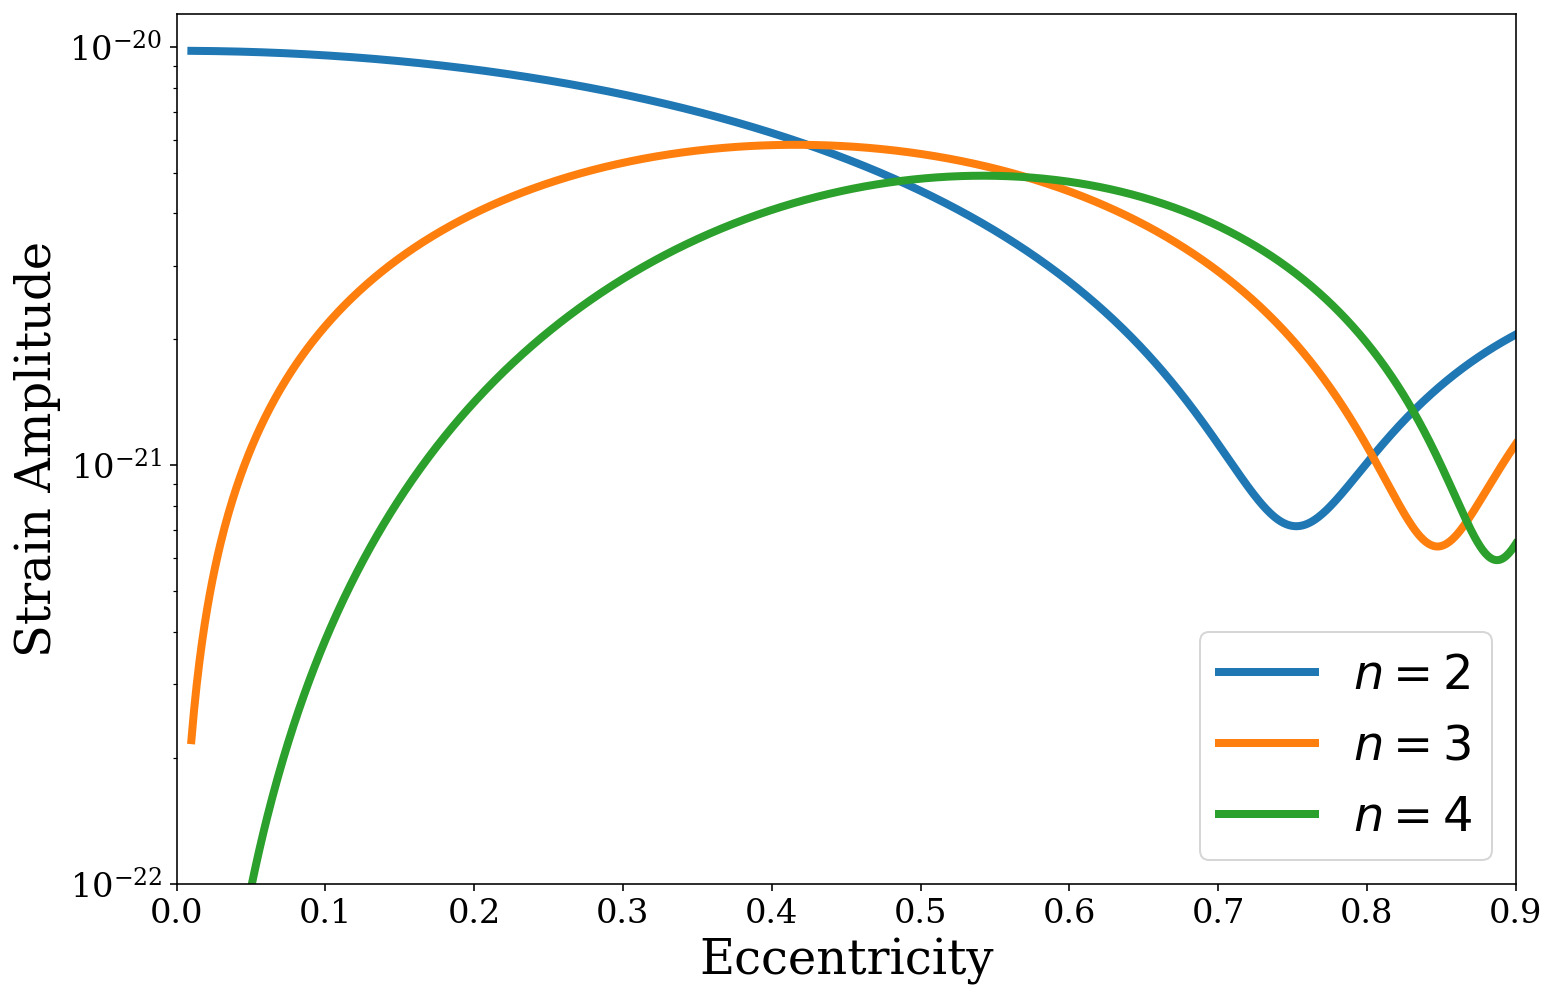

In [13]:
# add lines for the n = 2,3,4 harmonics
for n in [2, 3, 4]:
    plt.plot(ecc, ecc_plot_h_0_n[:, n - 1], label=r"$n={{{}}}$".format(n), lw=4)

# label the axes
plt.xlabel("Eccentricity")
plt.ylabel("Strain Amplitude")

# use a log scale for strain
plt.yscale("log")

# limit axes
plt.xlim(0, 0.9)
plt.ylim(1e-22, 1.2e-20)

# show a legend and the plot
plt.legend()
plt.show()

So here we can see that the strength of the $n = 2$ harmonic declines as binaries become more eccentric, such that the $n = 3$ harmonic actually becomes stronger than the $n = 2$ harmonic around $e \approx 0.33$. This repeats for $n = 4$ and onwards as each harmonic dominates at higher eccentricities.

But what about the total strain? This is just single harmonics, let's look at how the total varies too!

In [14]:
# sum the strain over all harmonics for each binary
h_0 = ecc_plot_h_0_n.sum(axis=1)

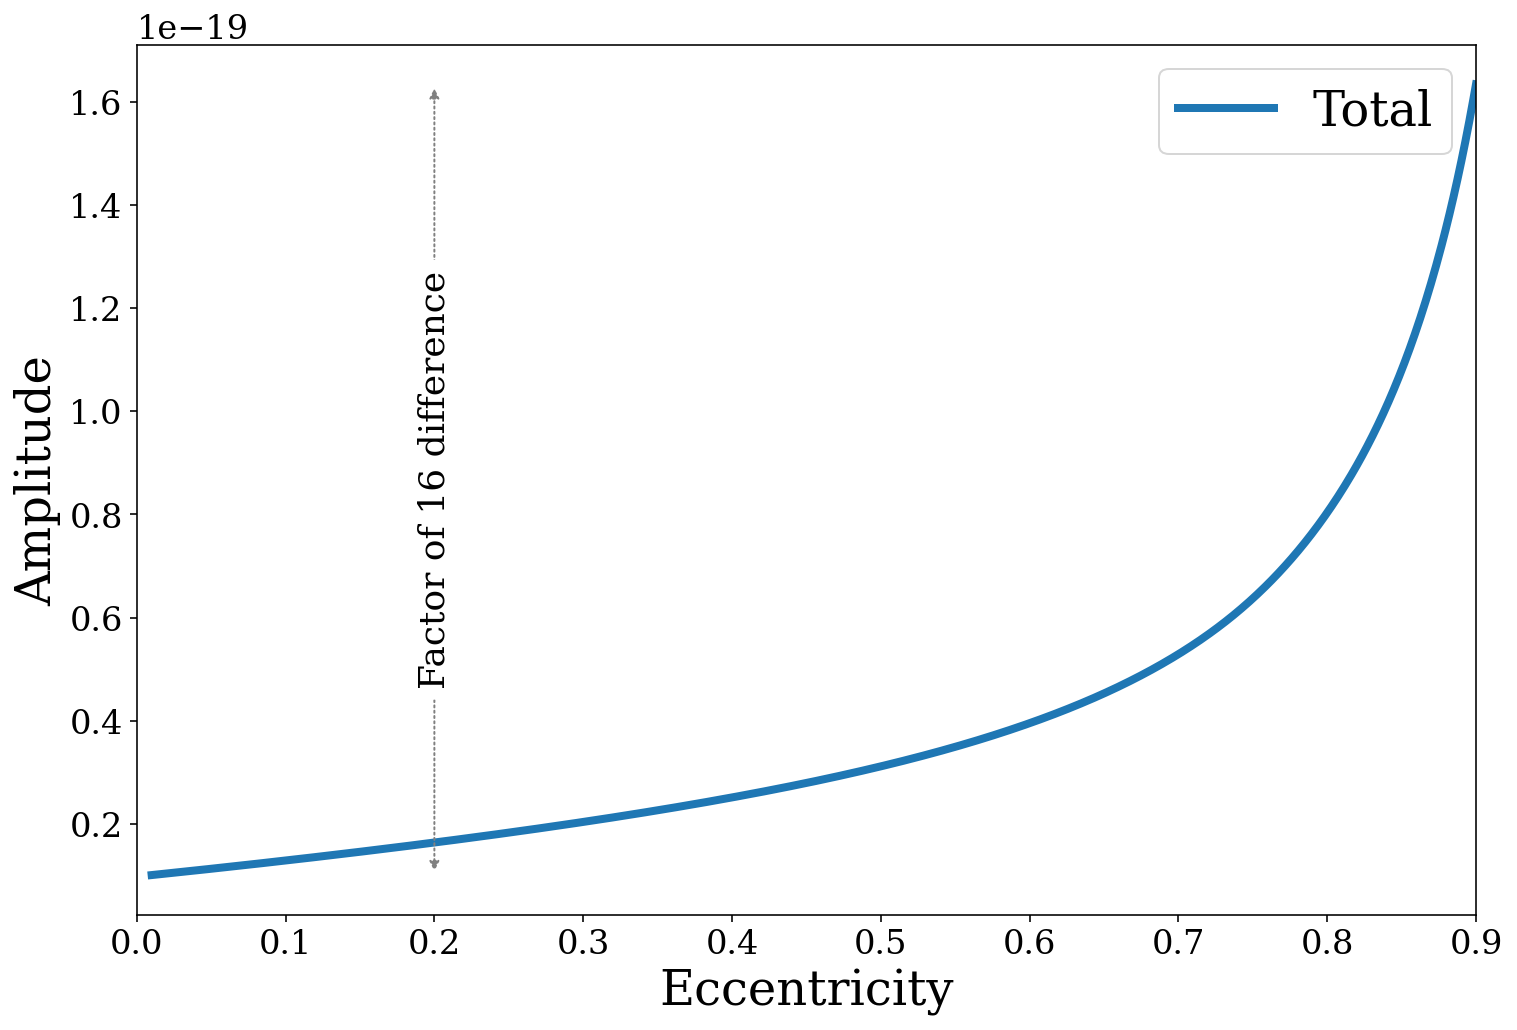

In [15]:
fig, ax = plt.subplots()

# plot the total
ax.plot(ecc, h_0, label="Total", lw=4)

# add an arrow and label with the change in strain
e_label = 0.2
ax.annotate("", xy=(e_label, h_0.min()), xytext=(e_label, h_0.max()),
            arrowprops=dict(arrowstyle="<|-|>", linestyle="dotted",
                            ec="grey", fc="grey"))
ax.annotate("Factor of {:1.0f} difference".format(h_0.max() / h_0.min()),
            xy=(e_label, h_0.min() + (h_0.max() - h_0.min()) / 2), rotation=90,
            ha="center", va="center",
            bbox=dict(boxstyle="round", fc="white", ec="none"), fontsize=18)

# label the axes
ax.set_xlabel("Eccentricity")
ax.set_ylabel("Amplitude")

# show a legend and the plot
ax.legend()
ax.set_xlim(0, 0.9)

plt.show()

Here we can see that higher eccentricity can dramatically increase the strain. Note that this may not necessarily increase the *detectability* of the binaries however, since the strain will be shifted to higher frequencies and hence *may* occur over a more noisy part of the LISA sensitivity curve.